# Adversarial Image Captioning Attack

The exploration of adversarial robustness in vision-language models has its roots in the work of Shekhar et al. (2017), who were among the first to test whether deep models for vision and language truly capture the interaction between the two modalities. Their study can be seen as an early stress test for multimodal understanding, questioning whether these models genuinely reason about images and text or simply exploit dataset regularities.

Following this, Chen et al. (2018) introduced *Show-and-Fool*, which extended the idea of adversarial attacks to image captioning models. At that time, most research focused on CNN-based image classifiers, where adversarial examples were already known to cause misclassifications through imperceptible pixel perturbations. However, captioning models pose a more complex challenge: instead of predicting a single class label, they generate natural language sentences, and semantically similar captions can be phrased in many different ways. Simply treating each caption as a distinct class would result in an enormous output space, far exceeding the number of training examples. Moreover, recurrent architectures such as RNNs had been less explored in adversarial contexts. Show-and-Fool addressed these challenges by formulating caption manipulation as an optimization problem over the input image, targeting either full sentences or specific keywords. Their results demonstrated that standard CNN-RNN captioning models could be fooled with visually imperceptible perturbations, revealing limited robustness against structured attacks.

Building on this line of work, Xu et al. (2019) proposed the *GEM* attack (Generalized Expectation Maximization), which reframed adversarial image captioning as a structured output learning problem with latent variables. By jointly optimizing over input perturbations and hidden word sequences using a max-margin objective, GEM achieved more controlled manipulations of the generated captions while keeping the perturbations imperceptible.

More recently, Li et al. (2024) introduced *AICAttack*, an adversarial image captioning attack that uses attention-based optimization. Their approach operates in a black-box setting, selecting candidate pixels for perturbation based on attention maps from the underlying captioning model. The idea is to subtly distort the generated captions while leaving the image visually unchanged. Li et al. use previous attacks such as Show-and-Fool and GEM as baselines and evaluate their method on attention-driven captioning architectures like Show-Attend-and-Tell (Xu et al., 2016) and BLIP (Li et al., 2022).

In this project, we aim to extend this line of research to more recent model architectures. All previous works were conducted on CNN-RNN based captioning models, which are no longer the state of the art. We therefore investigate whether the AICAttack principle can be applied to Vision Transformer–based architectures, more particular the ViT-GPT2 image captioning model (Srija et al., 2025). By doing so, we explore whether we can apply AICAttack to fool modern attention-driven encoder-decoder models that combine transformer-based vision and language components.

### Import Libraries, Set Seeds, and Select GPU

In [150]:
# Standard libraries
import json
import os

# Third party packages
import kagglehub
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, ViTImageProcessor, VisionEncoderDecoderModel

# Reproducibility
np.random.seed(42)
torch.manual_seed(42)

In [151]:
# GPU setup
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


### Load COCO Mini Dataset

In [152]:
# Download dataset
data_path = kagglehub.dataset_download(
    "nagasai524/mini-coco2014-dataset-for-image-captioning")

In [153]:
def load_captions(dataset_path):
    """Load image_id -> list of captions mapping from captions.json."""
    captions_path = os.path.join(dataset_path, "captions.json")
    with open(captions_path, "r") as f:
        data = json.load(f)

    annotations = data["annotations"] if isinstance(data, dict) else data

    captions = {}
    for ann in annotations:
        img_id = ann["image_id"]
        captions.setdefault(img_id, []).append(ann["caption"])
    return captions

In [154]:
def find_image_folder(dataset_path, ext=".jpg"):
    """Find first folder under dataset_path that contains image files."""
    for root, _, files in os.walk(dataset_path):
        if any(f.lower().endswith(ext) for f in files):
            return root
    raise RuntimeError(f"No image folder with *{ext} found under {dataset_path}")

In [155]:
captions = load_captions(data_path)
img_folder = find_image_folder(data_path)
img_ids = sorted(captions.keys())

print(f"Dataset loaded, {len(img_ids)} images with captions")

Dataset loaded, 18783 images with captions


### Image Loading Helper

In [156]:
def get_image(idx):
    """Load image and its captions by index in img_ids."""
    img_id = img_ids[idx]

    # Try common filename patterns
    candidates = [
        os.path.join(img_folder, f"COCO_train2014_{img_id:012d}.jpg"),
        os.path.join(img_folder, f"{img_id}.jpg"),
    ]

    for img_path in candidates:
        if os.path.exists(img_path):
            img = Image.open(img_path).convert("RGB")
            return img, captions[img_id]

    raise FileNotFoundError(f"No image file found for image_id {img_id}")


### Visual Inspection of a Sample Image

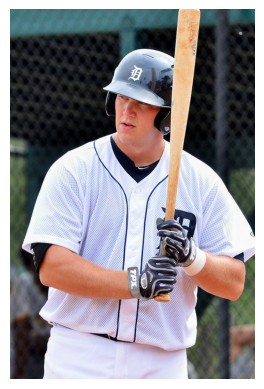

Image index: 6006, image_id: 190530
Ground truth captions:
  - A baseball player for the Detroit Lions getting ready to bat.
  - A batter with batting helmet getting ready to hit.
  - A baseball batter with his bat up, waiting for a pitch.
  - There is a baseball player holding his bat  in his hands
  - A baseball player in uniform holding a bat.


In [195]:
# Choose an image to show
idx = 6006

img, caps = get_image(idx)

plt.imshow(img)
plt.axis("off")
plt.show()

print(f"Image index: {idx}, image_id: {img_ids[idx]}")
print("Ground truth captions:")
for cap in caps:
    print(f"  - {cap}")


### Load ViT-GPT2

In [158]:
model_name = "nlpconnect/vit-gpt2-image-captioning"

model = VisionEncoderDecoderModel.from_pretrained(
    model_name,
    attn_implementation="eager").to(device)

feature_extractor = ViTImageProcessor.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

model.eval()

print(f"Loaded model: {model_name}")
print(f"Decoder attention implementation: {model.config.decoder._attn_implementation}")

Loaded model: nlpconnect/vit-gpt2-image-captioning
Decoder attention implementation: eager


In [159]:
@torch.no_grad()
def generate_caption_and_attention(img, max_length=16):
    """
    Generate a caption for a PIL image and return:
    - caption (str)
    - cross_attentions (list of tensors)
    - encoder_hidden_states (tensor)
    """
    # Image -> pixel_values
    pixel_values = feature_extractor(images=img, return_tensors="pt").pixel_values.to(device)

    # Encode image
    encoder_outputs = model.encoder(pixel_values=pixel_values)
    encoder_hidden_states = encoder_outputs.last_hidden_state  # [1, 197, hidden_dim]

    # Generate caption ids
    generated_ids = model.generate(
        pixel_values,
        max_length=max_length,
        num_beams=1)

    # Run decoder once over full sequence to get cross-attentions
    decoder_outputs = model.decoder(
        input_ids=generated_ids,
        encoder_hidden_states=encoder_hidden_states,
        output_attentions=True,
        return_dict=True,
        use_cache=False)

    caption = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

    return caption, decoder_outputs.cross_attentions, encoder_hidden_states


In [160]:
def aggregate_cross_attention(cross_attentions, img_size, patch_size=14):
    """
    Aggregate cross-attention over heads and tokens into a 2D heatmap
    in image resolution (sentence-based aggregation).
    
    cross_attentions: list of tensors, each [1, num_heads, tgt_len, src_len]
                      src_len = 1 (CLS) + patch_size^2
    img_size: (width, height) of the original image
    """
    # Take last decoder layer (most informative)
    last_layer = cross_attentions[-1]          # [1, num_heads, tgt_len, src_len]
    last_layer = last_layer.squeeze(0)         # [num_heads, tgt_len, src_len]

    # Average over heads and decoder tokens
    avg_over_heads = last_layer.mean(dim=0)    # [tgt_len, src_len]
    avg_over_tokens = avg_over_heads.mean(dim=0)  # [src_len]

    # Drop CLS token and keep only patch tokens
    patch_attention = avg_over_tokens[1:]      # [patch_size^2]

    # Reshape to patch grid
    attention_map = patch_attention.reshape(patch_size, patch_size).cpu().numpy()

    # Normalize to [0, 1]
    attention_map -= attention_map.min()
    denom = attention_map.max() if attention_map.max() > 0 else 1e-8
    attention_map /= denom

    # Upsample to original image size
    w, h = img_size
    attn_img = Image.fromarray((attention_map * 255).astype(np.uint8))
    attn_resized = attn_img.resize((w, h), resample=Image.BICUBIC)

    return np.array(attn_resized) / 255.0

In [161]:
def show_image_and_attention(img, caption, attention_heatmap):
    """Plot original image, attention heatmap, and overlay."""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # 1) Original image
    axes[0].imshow(img)
    axes[0].set_title(f"Original image\nCaption: '{caption}'", fontsize=10)
    axes[0].axis("off")

    # 2) Heatmap only
    axes[1].imshow(attention_heatmap, cmap="hot")
    axes[1].set_title("Cross-attention heatmap\n(sentence-based)", fontsize=10)
    axes[1].axis("off")

    # 3) Overlay
    axes[2].imshow(img)
    axes[2].imshow(attention_heatmap, cmap="hot", alpha=0.5)
    axes[2].set_title("Attention overlay\n(red = high attention)", fontsize=10)
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()


### Example: Pick an Image, Get Caption and Attention and Visualize

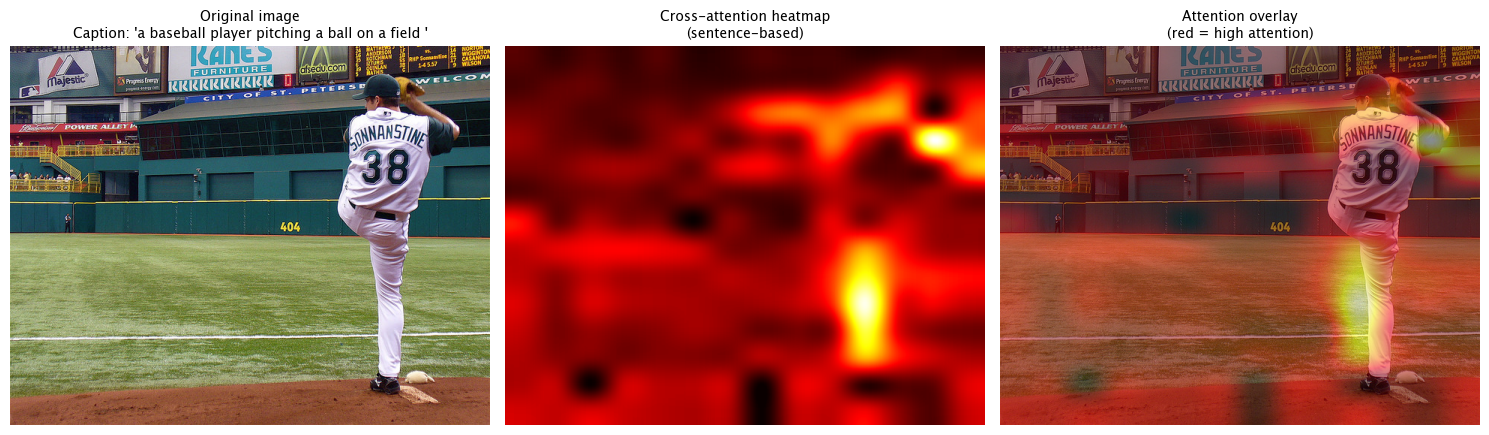

Image index: 6002, image_id: 190382

Ground-truth captions:
  - A man with a baseball uniform on pitching the ball. 
  - A professional baseball player curls in to pitch
  - a man is preparing to pitch a ball in a baseball game
  - A baseball pitcher getting ready to throw a pitch. 
  - A baseball player for the Sonnan Stine is about to throw the pitch. 


In [162]:
img, gt_caps = get_image(idx)

caption, cross_attentions, _ = generate_caption_and_attention(img)
attention_heatmap = aggregate_cross_attention(cross_attentions, img.size)

show_image_and_attention(img, caption, attention_heatmap)

print(f"Image index: {idx}, image_id: {img_ids[idx]}")
print("\nGround-truth captions:")
for cap in gt_caps:
    print(f"  - {cap}")

## Attack Pipeline

### Get the Candidate Mask

Original caption: a baseball player holding a bat on a field 
Candidate region size: 137125
Using k_pixels = 10000

=== Generation 1/5 ===
Improved: Loss 9.5501 → 9.5591
Improved: Loss 9.5560 → 9.5700
Improved: Loss 9.5600 → 9.5665

=== Generation 2/5 ===
Improved: Loss 9.5611 → 9.5684
Improved: Loss 9.5446 → 9.5573
Improved: Loss 9.5704 → 9.5720
Improved: Loss 9.5638 → 9.5726

=== Generation 3/5 ===
Improved: Loss 9.5573 → 9.5581

=== Generation 4/5 ===
Improved: Loss 9.5591 → 9.5612
Improved: Loss 9.5610 → 9.5656
Improved: Loss 9.5581 → 9.5650

=== Generation 5/5 ===
Improved: Loss 9.5612 → 9.5646
Improved: Loss 9.5650 → 9.5658

Best loss after 5 gens: 9.5726
Adversarial caption: a baseball player holding a bat on a field 

Original: a baseball player holding a bat on a field 
Adversarial: a baseball player holding a bat on a field 
BLEU(orig, adv) = 1.0000


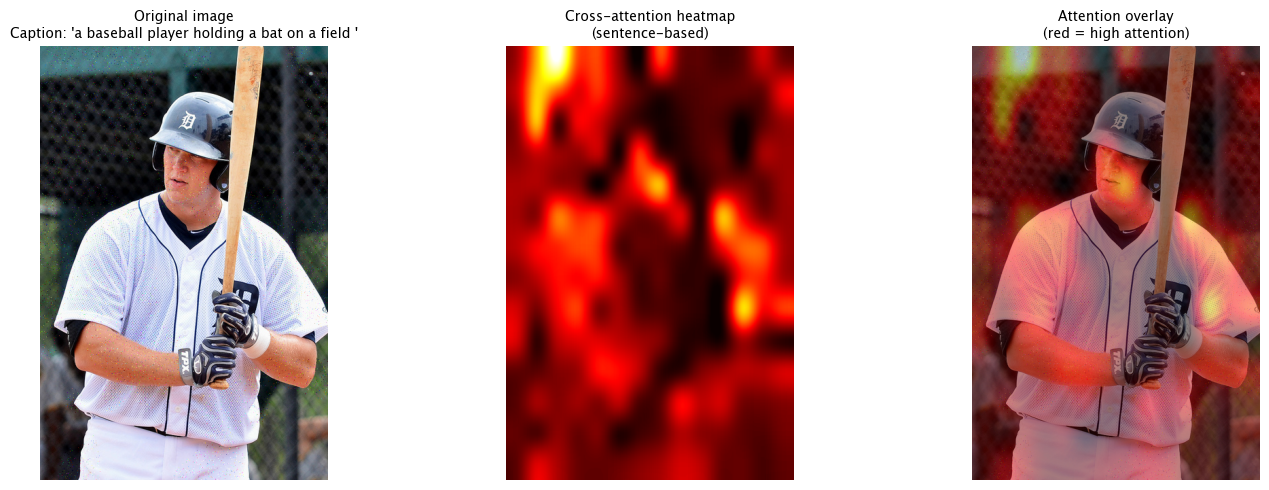

In [197]:
import random
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# ---------- Optional: BLEU, nur für Analyse am Ende ----------

def compute_bleu(ref, hyp):
    smoothie = SmoothingFunction().method4
    return sentence_bleu([ref.split()], hyp.split(), smoothing_function=smoothie)

# ---------- Candidate Region & Perturbation ----------

def select_candidate_region(attention_map, top_percent=50):
    """
    attention_map: 2D numpy array (H, W) in [0,1]
    Rückgabe: Liste von (y, x) Pixel-Koordinaten in der Top-X%-Region.
    """
    flat = attention_map.flatten()
    threshold = np.percentile(flat, 100 - top_percent)
    mask = attention_map >= threshold
    coords = np.argwhere(mask)  # (y, x)
    return [tuple(c) for c in coords]


def apply_perturbation(base_img, coords, deltas):
    """
    base_img: PIL.Image (RGB)
    coords: Liste von (y, x)
    deltas: np.array shape (k_pixels, 3) mit RGB-Offsets
    """
    img = np.array(base_img).astype(np.float32)
    h, w, _ = img.shape

    for (y, x), delta in zip(coords, deltas):
        if 0 <= y < h and 0 <= x < w:
            img[y, x, :] = np.clip(img[y, x, :] + delta, 0, 255)

    return Image.fromarray(img.astype(np.uint8))

# ---------- Fitness: Model-Loss (nicht BLEU) ----------

def fitness_fn_loss(base_img, coords, deltas, orig_ids):
    """
    Fitness = Cross-Entropy-Loss des Modells für die Original-Caption.
    Je größer der Loss, desto besser (Caption wird unwahrscheinlicher).
    """
    perturbed_img = apply_perturbation(base_img, coords, deltas)

    pixel_values = feature_extractor(
        images=perturbed_img, return_tensors="pt"
    ).pixel_values.to(device)

    with torch.no_grad():
        outputs = model(pixel_values=pixel_values, labels=orig_ids)
        loss = outputs.loss.item()

    return loss, perturbed_img

# ---------- Differential Evolution Attack ----------

def differential_evolution_attack(
    base_img,
    attention_map,
    orig_ids,              # Token-IDs der Original-Caption (Tensor[1, L])
    popsize=10,
    k_pixels=2000,
    delta_range=30,
    F=0.5,
    CR=0.8,
    generations=5,
):
    candidate_coords = select_candidate_region(attention_map, top_percent=50)
    print(f"Candidate region size: {len(candidate_coords)}")

    # k_pixels darf nicht größer als Candidate Region sein
    k_pixels_eff = min(k_pixels, len(candidate_coords))
    print(f"Using k_pixels = {k_pixels_eff}")

    # Fixe Pixel-Subset für diese Attacke (Paper sampelt auch, aber so ist es einfacher)
    coords = random.sample(candidate_coords, k_pixels_eff)

    # --- Initial Population: (deltas, loss) ---
    population = []
    for _ in range(popsize):
        deltas = np.random.randint(
            -delta_range, delta_range + 1, (k_pixels_eff, 3)
        ).astype(np.float32)
        loss, _ = fitness_fn_loss(base_img, coords, deltas, orig_ids)
        population.append((deltas, loss))

    for gen in range(generations):
        print(f"\n=== Generation {gen+1}/{generations} ===")

        new_population = []
        for i, (deltas_i, loss_i) in enumerate(population):
            # 1) Mutation: wähle 3 andere Individuen
            idxs = random.sample([x for x in range(popsize) if x != i], 3)
            a, b, c = [population[idx][0] for idx in idxs]
            mutant = a + F * (b - c)
            mutant = np.clip(mutant, -delta_range, delta_range)

            # 2) Crossover
            cross_mask = np.random.rand(k_pixels_eff, 3) < CR
            trial = np.where(cross_mask, mutant, deltas_i)

            # 3) Fitness berechnen (Loss ↑)
            loss_trial, _ = fitness_fn_loss(base_img, coords, trial, orig_ids)

            # 4) Selektion: behalte das bessere (größerer Loss)
            if loss_trial > loss_i:
                new_population.append((trial, loss_trial))
                print(f"Improved: Loss {loss_i:.4f} → {loss_trial:.4f}")
            else:
                new_population.append((deltas_i, loss_i))

        population = new_population

    # --- Bestes Individuum auswählen ---
    best_deltas, best_loss = max(population, key=lambda x: x[1])
    best_loss, best_img = fitness_fn_loss(base_img, coords, best_deltas, orig_ids)
    adv_caption, _, _ = generate_caption_and_attention(best_img)

    print(f"\nBest loss after {generations} gens: {best_loss:.4f}")
    print(f"Adversarial caption: {adv_caption}")

    return best_img, adv_caption, best_loss

# ---------- Attacke ausführen ----------

# 1) Originale Caption & Attention
orig_caption, cross_attn, _ = generate_caption_and_attention(img)
print("Original caption:", orig_caption)

attn_map = aggregate_cross_attention(cross_attn, img.size)

# 2) Original-Caption tokenisieren (für den Loss)
orig_ids = tokenizer(orig_caption, return_tensors="pt").input_ids.to(device)

# 3) Attacke
adv_img, adv_caption, best_loss = differential_evolution_attack(
    base_img=img,
    attention_map=attn_map,
    orig_ids=orig_ids,
    popsize=8,
    k_pixels=10000,      # hier kannst du spielen: 1000–5000 ist oft sinnvoll
    generations=5,
    delta_range=100      # maximale RGB-Änderung pro Kanal
)

# 4) BLEU nur fürs Reporting
bleu_final = compute_bleu(orig_caption, adv_caption)

print("\nOriginal:", orig_caption)
print("Adversarial:", adv_caption)
print(f"BLEU(orig, adv) = {bleu_final:.4f}")

show_image_and_attention(adv_img, adv_caption, attn_map)


# Ab hier vorherige Version

In [118]:
def get_topk_candidate_pixels(attention_heatmap, k):
    """
    Select top-k pixels with highest attention as candidate region.
    Returns list of (y, x) indices.
    """
    flat = attention_heatmap.flatten()
    k = min(k, flat.size)
    idxs = np.argpartition(flat, -k)[-k:]
    ys, xs = np.unravel_index(idxs, attention_heatmap.shape)
    return list(zip(ys, xs))


def show_candidate_region(img, attention_heatmap, candidate_pixels):
    """
    Visualize original image and candidate region (pixels we may perturb).
    """
    mask = np.zeros(attention_heatmap.shape, dtype=bool)
    for y, x in candidate_pixels:
        mask[y, x] = True

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Original image
    axes[0].imshow(img)
    axes[0].set_title("Original image")
    axes[0].axis("off")

    # Candidate overlay
    axes[1].imshow(img)
    axes[1].imshow(mask, cmap="Reds", alpha=0.6)
    axes[1].set_title("Candidate region (pixels we may perturb)")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

Attack index: 6000
Base caption: 'a cat laying on top of a car '
Number of candidate pixels: 1000


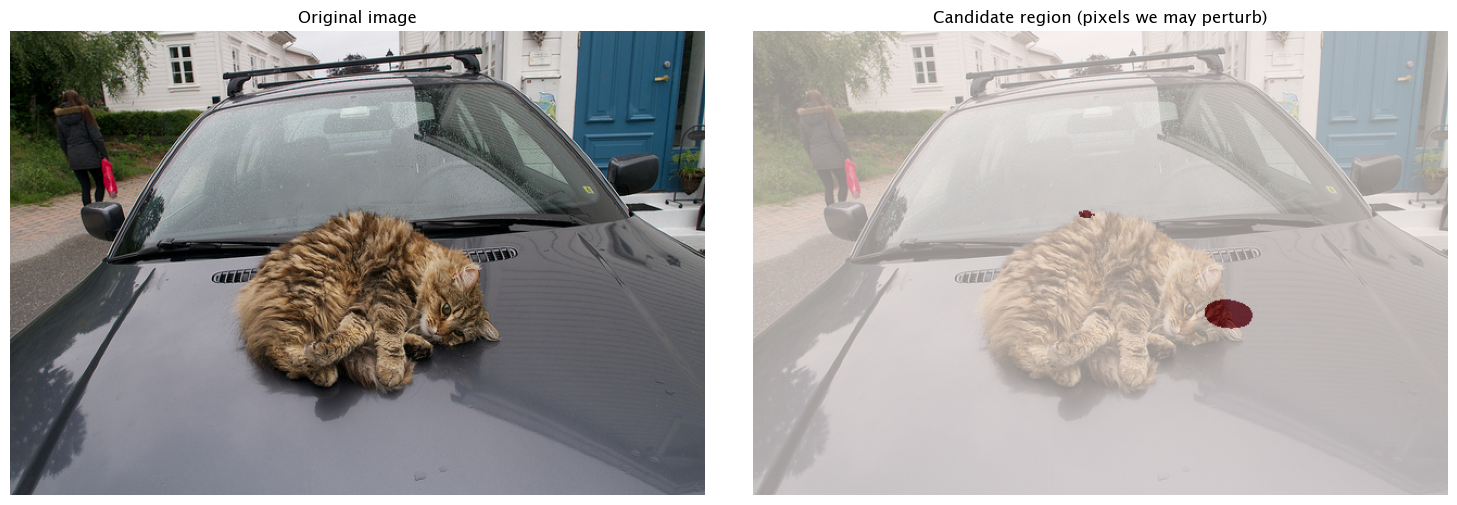

In [119]:
ATTACK_IDX = idx

# Image and Ground Truth Captions
base_img, gt_caps = get_image(ATTACK_IDX)

# 2) Caption + Cross-Attention vom Modell holen
base_caption, cross_attentions, _ = generate_caption_and_attention(base_img)

# 3) Attention-Heatmap aggregieren
attention_heatmap = aggregate_cross_attention(cross_attentions, base_img.size)

# 4) Top-k Pixel als Candidate Region wählen
candidate_pixels = get_topk_candidate_pixels(attention_heatmap, k=1000)

print(f"Attack index: {ATTACK_IDX}")
print(f"Base caption: '{base_caption}'")
print(f"Number of candidate pixels: {len(candidate_pixels)}")

# 5) Candidate Region visualisieren
show_candidate_region(base_img, attention_heatmap, candidate_pixels)


In [120]:
def image_to_array(img):
    """Convert PIL image to uint8 numpy array of shape (H, W, 3)."""
    return np.array(img).astype(np.uint8)


def array_to_image(arr):
    """Convert numpy array (H, W, 3) back to PIL image."""
    return Image.fromarray(arr.astype(np.uint8))


def apply_perturbation(base_array, delta_vec, candidate_pixels):
    """
    Apply a perturbation vector to the candidate pixels of an image.
    
    base_array: numpy array (H, W, 3), uint8
    delta_vec: 1D numpy array of length 3 * len(candidate_pixels)
               [dR1, dG1, dB1, dR2, dG2, dB2, ...]
    candidate_pixels: list of (y, x) positions
    """
    H, W, C = base_array.shape
    assert C == 3, "Expected RGB image"
    num_pixels = len(candidate_pixels)
    assert delta_vec.shape[0] == 3 * num_pixels, "delta_vec length mismatch"

    # work on a float copy so we can add positive/negative deltas
    perturbed = base_array.astype(np.float32).copy()
    deltas = delta_vec.reshape(num_pixels, 3)

    for (y, x), d in zip(candidate_pixels, deltas):
        # add deltas to this pixel (R,G,B)
        perturbed[y, x, :] += d

    # clip back to valid image range
    perturbed = np.clip(perturbed, 0, 255).astype(np.uint8)
    return array_to_image(perturbed)


# base image as numpy array (used for all perturbations)
base_array = image_to_array(base_img)

In [121]:
@torch.no_grad()
def generate_caption(img, max_length=16):
    pixel_values = feature_extractor(images=img, return_tensors="pt").pixel_values.to(device)
    generated_ids = model.generate(pixel_values, max_length=max_length, num_beams=1)
    return tokenizer.decode(generated_ids[0], skip_special_tokens=True)

# Prepare token IDs of the base caption (this is the fixed target for the loss)
base_ids = tokenizer(
    base_caption,
    return_tensors="pt",
    add_special_tokens=True,
).input_ids.to(device)


@torch.no_grad()
def caption_loss_for_image(img):
    """
    Compute cross-entropy loss of the fixed base caption given the image.
    Higher loss = caption less compatible with the image.
    """
    pixel_values = feature_extractor(images=img, return_tensors="pt").pixel_values.to(device)
    outputs = model(pixel_values=pixel_values, labels=base_ids)
    return outputs.loss.item()


# Loss for the original (unperturbed) image
base_loss = caption_loss_for_image(base_img)
print(f"Base loss for original image: {base_loss:.4f}")

Base loss for original image: 9.1638


In [122]:
# Better fitness with actual caption comparison
@torch.no_grad()
def fitness_caption_change(x):
    """
    Fitness based on actual caption change
    """
    perturbed_img = apply_perturbation(base_array, x, candidate_pixels)
    adv_caption = generate_caption(perturbed_img)
    
    # Jaccard distance between word sets
    base_words = set(base_caption.lower().split())
    adv_words = set(adv_caption.lower().split())
    
    if not base_words or not adv_words:
        overlap = 0.0
    else:
        overlap = len(base_words & adv_words) / len(base_words | adv_words)
    
    # Perturbation size penalty
    norm_penalty = LAMBDA_REG * (np.linalg.norm(x) / (255.0 * np.sqrt(x.size)))
    
    # Lower overlap = better attack
    # Return negative (DE maximizes, we want to minimize overlap)
    fitness_score = -(overlap + norm_penalty)
    
    return fitness_score

# Run with better hyperparameters
LAMBDA_REG = 0.0  # no regularization for first test

best_x, best_f = differential_evolution(
    fitness_fn=fitness_caption_change,
    dim=dim,
    pop_size=20,      # more individuals
    generations=10,   # more iterations
    F=0.8,           # stronger mutation
    CR=0.9,          # higher crossover
    eps=50.0,        # allow stronger perturbations
)

AssertionError: delta_vec length mismatch

In [123]:
def differential_evolution(
    fitness_fn,
    dim,
    pop_size=8,
    generations=5,
    F=0.5,
    CR=0.7,
    eps=20.0,
    random_seed=42):
    """
    Very simple Differential Evolution (DE/rand/1/bin).
    
    fitness_fn: function x -> scalar (higher = better)
    dim: dimensionality of x (here: 3 * len(candidate_pixels))
    pop_size: number of individuals in the population
    generations: number of DE generations
    F: mutation factor
    CR: crossover rate
    eps: initial range for parameters: x ~ U[-eps, +eps]
    """
    rng = np.random.default_rng(random_seed)

    # 1) Initialize population with random vectors
    pop = rng.uniform(low=-eps, high=eps, size=(pop_size, dim)).astype(np.float32)
    fitness_vals = np.array([fitness_fn(ind) for ind in pop], dtype=np.float32)

    best_idx = int(np.argmax(fitness_vals))
    best_x = pop[best_idx].copy()
    best_f = float(fitness_vals[best_idx])

    print(f"Initial best fitness: {best_f:.4f}")

    # 2) Iterate over generations
    for gen in range(generations):
        print(f"\n--- Generation {gen + 1}/{generations} ---")

        for i in range(pop_size):
            # Choose indices for mutation (a, b, c all different and all != i)
            idxs = list(range(pop_size))
            idxs.remove(i)
            a, b, c = rng.choice(idxs, size=3, replace=False)

            x_a, x_b, x_c = pop[a], pop[b], pop[c]

            # Mutation: v = x_a + F * (x_b - x_c)
            v = x_a + F * (x_b - x_c)

            # Crossover: binomial
            cross_mask = rng.random(dim) < CR
            # Ensure at least one component comes from v
            j_rand = rng.integers(0, dim)
            cross_mask[j_rand] = True

            u = np.where(cross_mask, v, pop[i])

            # Evaluate trial vector
            f_u = fitness_fn(u)

            # Selection: keep trial if it is better
            if f_u > fitness_vals[i]:
                pop[i] = u
                fitness_vals[i] = f_u

                # Update global best if necessary
                if f_u > best_f:
                    best_f = float(f_u)
                    best_x = u.copy()

        print(f"Best fitness after generation {gen + 1}: {best_f:.4f}")

    return best_x, best_f

In [124]:
# Dimension of the search space
dim = 3 * len(candidate_pixels)
print(f"Dimensionality of x: {dim}")

best_x, best_f = differential_evolution(
    fitness_fn=fitness,
    dim=dim,
    pop_size=6,      # keep small because each call runs the model
    generations=3,   # small number of iterations for testing
    F=0.6,
    CR=0.7,
    eps=20.0,       # allow strong per-channel perturbations
)

print("\n=== Differential Evolution finished ===")
print(f"Best fitness found (loss increase): {best_f:.4f}")

# Create best adversarial image from the found perturbation
best_img = apply_perturbation(base_array, best_x, candidate_pixels)
best_caption = generate_caption(best_img)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(base_img)
plt.title(f"Original\n'{base_caption}'", fontsize=9)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(best_img)
plt.title(f"Adversarial\n'{best_caption}'", fontsize=9)
plt.axis("off")

plt.tight_layout()
plt.show()

print(f"\nOriginal caption : '{base_caption}'")
print(f"Adversarial cap. : '{best_caption}'")
print(f"Base loss        : {base_loss:.4f}")
print(f"Best loss (base+f): {base_loss + best_f:.4f}")

Dimensionality of x: 3000


NameError: name 'fitness' is not defined

In [25]:
# Check what magnitudes the DE is actually using
print(f"Best perturbation stats:")
print(f"  Min delta: {best_x.min():.2f}")
print(f"  Max delta: {best_x.max():.2f}")
print(f"  Mean abs:  {np.abs(best_x).mean():.2f}")
print(f"  Std:       {best_x.std():.2f}")

# Check L-infinity norm (max single pixel change)
deltas_reshaped = best_x.reshape(-1, 3)
per_pixel_max = np.abs(deltas_reshaped).max(axis=1)
print(f"\n  L-inf norm (max pixel change): {per_pixel_max.max():.2f}")
print(f"  Number of pixels with change > 10: {(per_pixel_max > 10).sum()}")
print(f"  Number of pixels with change > 30: {(per_pixel_max > 30).sum()}")

Best perturbation stats:


NameError: name 'best_x' is not defined

In [126]:
# Install nltk if needed
import nltk
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def compute_bleu(reference_caption, candidate_caption):
    """
    Compute BLEU score between reference and candidate.
    Lower BLEU = more different = better attack
    """
    ref_tokens = reference_caption.lower().split()
    cand_tokens = candidate_caption.lower().split()
    
    # BLEU needs list of references (can be multiple)
    references = [ref_tokens]
    
    # Smoothing function to avoid zero scores
    smoothing = SmoothingFunction().method1
    
    # Compute BLEU (0 to 1, higher = more similar)
    bleu = sentence_bleu(references, cand_tokens, smoothing_function=smoothing)
    
    return bleu

# Test
test_bleu = compute_bleu(base_caption, base_caption)
print(f"BLEU(same caption): {test_bleu:.4f}")

test_bleu2 = compute_bleu(base_caption, "a dog running in water")
print(f"BLEU(different caption): {test_bleu2:.4f}")

BLEU(same caption): 1.0000
BLEU(different caption): 0.0295


In [123]:
!pip install nltk

Traceback (most recent call last):
  File "/Users/sebastianuedingslohmann/Desktop/NLP_Project/Advanced-Machine-Learning-for-Natural-Language-Processing/.venv/bin/pip", line 5, in <module>
    from pip._internal.cli.main import main
ModuleNotFoundError: No module named 'pip'


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [127]:
@torch.no_grad()
def fitness_bleu(x):
    """
    Fitness based on BLEU score (as in the paper).
    Lower BLEU = better attack.
    We return negative BLEU because DE maximizes.
    """
    # Apply perturbation
    perturbed_img = apply_perturbation(base_array, x, candidate_pixels)
    
    # Generate caption
    adv_caption = generate_caption(perturbed_img)
    
    # Compute BLEU score
    bleu = compute_bleu(base_caption, adv_caption)
    
    # L2 penalty for perturbation size
    norm_penalty = LAMBDA_REG * (np.linalg.norm(x) / (255.0 * np.sqrt(x.size)))
    
    # Return negative (DE maximizes, we want to minimize BLEU + penalty)
    return -(bleu + norm_penalty)

# Quick test
print("Testing BLEU-based fitness:")
x_zero = np.zeros(dim, dtype=np.float32)
f_zero = fitness_bleu(x_zero)
print(f"  Fitness(zero perturbation): {f_zero:.4f}")

x_random = np.random.uniform(-50, 50, size=dim).astype(np.float32)
f_random = fitness_bleu(x_random)
print(f"  Fitness(random perturbation): {f_random:.4f}")

Testing BLEU-based fitness:
  Fitness(zero perturbation): -1.0000
  Fitness(random perturbation): -1.0000


Attack index: 6000
Base caption: 'a cat laying on top of a car '
Number of candidate pixels: 15000


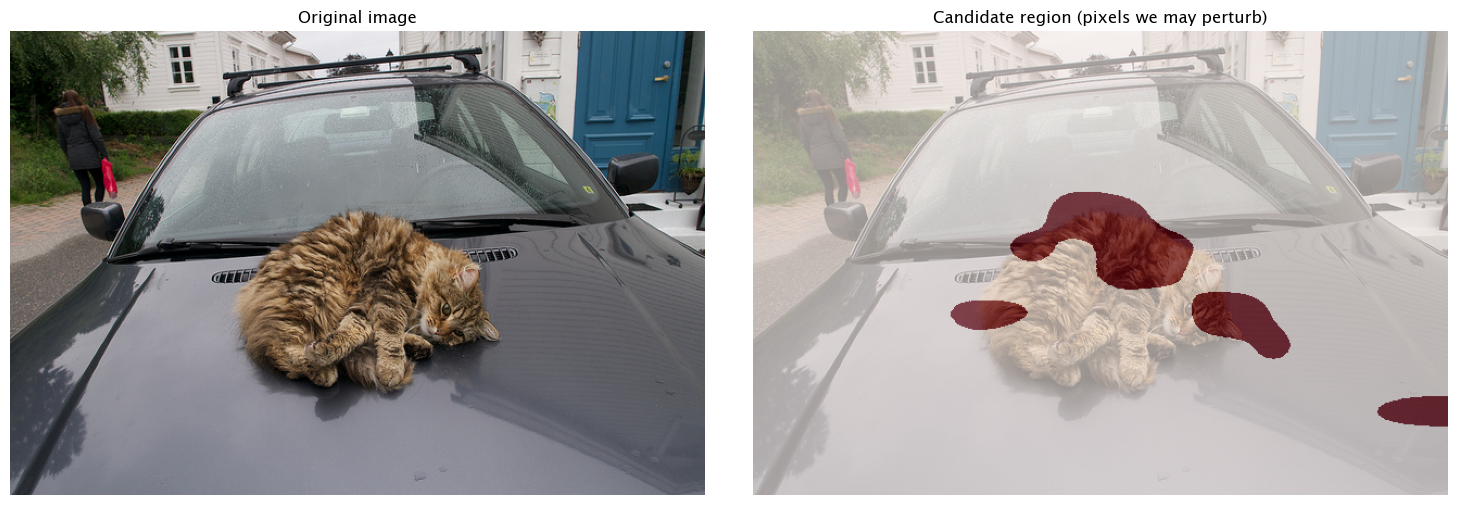


Base caption loss: 9.1638

Initial best fitness: 14.1458
--- Generation 1/2 ---
Best fitness after generation 1: 14.1477
--- Generation 2/2 ---
Best fitness after generation 2: 14.1487

=== Differential Evolution finished ===
Best fitness found: 14.1487  (base loss: 9.1638)

Base caption:          a cat laying on top of a car 
Adv caption (det):     a cat laying on top of a car 
Adv caption (sample):  the cat likes being touched by the car of someone 


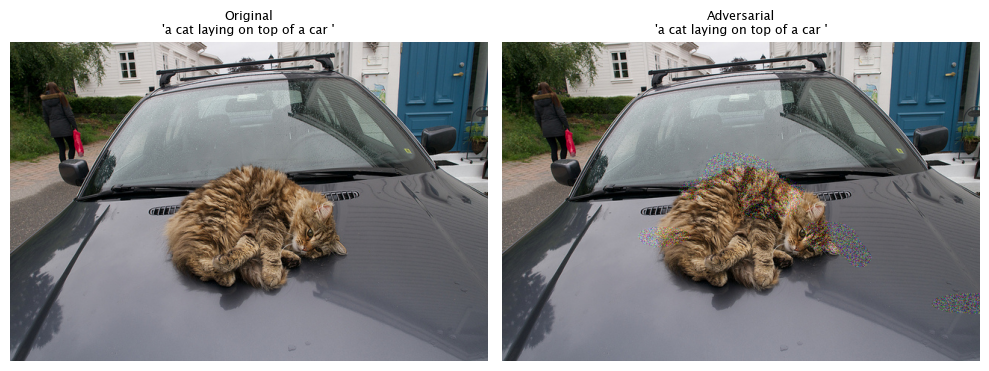

In [131]:
# ============================================
# AICAttack-Style Pipeline v3 (ViT-GPT2)
# - größere Candidate Region
# - Fitness = Caption-Loss + Bonus bei Caption-Change
# - eigene DE-Implementierung (Maximierung)
# ============================================

import numpy as np
import torch
import matplotlib.pyplot as plt

# --------------------------------------------------
# 1) Hilfsfunktionen für Captioning + Attention
# --------------------------------------------------

@torch.no_grad()
def generate_caption(
    img,
    max_length: int = 20,
    do_sample: bool = False,
    temperature: float = 1.0,
    top_p: float = 0.9,
):
    """
    Wrapper um model.generate für deterministische oder stochastische Captioning.
    """
    pixel_values = feature_extractor(images=img, return_tensors="pt").pixel_values.to(device)

    gen_kwargs = dict(
        max_length=max_length,
        num_beams=1,
        do_sample=do_sample,
    )
    if do_sample:
        gen_kwargs.update(dict(temperature=temperature, top_p=top_p))

    output_ids = model.generate(pixel_values=pixel_values, **gen_kwargs)
    caption = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return caption


@torch.no_grad()
def generate_caption_and_cross_attention(img, max_length: int = 20):
    """
    1) Deterministische Caption
    2) Cross-Attention Maps zu genau dieser Caption
    """
    pixel_values = feature_extractor(images=img, return_tensors="pt").pixel_values.to(device)

    # Schritt 1: deterministische Caption generieren
    gen_ids = model.generate(
        pixel_values=pixel_values,
        max_length=max_length,
        num_beams=1,
        do_sample=False,
    )
    base_caption = tokenizer.decode(gen_ids[0], skip_special_tokens=True)

    # Schritt 2: Encoder + Decoder mit output_attentions=True
    encoder_outputs = model.encoder(pixel_values=pixel_values)
    encoder_hidden_states = encoder_outputs.last_hidden_state

    decoder_outputs = model.decoder(
        input_ids=gen_ids,
        encoder_hidden_states=encoder_hidden_states,
        output_attentions=True,
        return_dict=True,
        use_cache=False,
    )
    cross_attentions = decoder_outputs.cross_attentions

    return base_caption, cross_attentions


# --------------------------------------------------
# 2) Bild auswählen, Base-Caption + Attention holen
# --------------------------------------------------

ATTACK_IDX = idx  # oder fix eine Zahl wählen
base_img, gt_caps = get_image(ATTACK_IDX)

base_caption, cross_attentions = generate_caption_and_cross_attention(
    base_img,
    max_length=20,
)

attention_heatmap = aggregate_cross_attention(cross_attentions, base_img.size)

# --------------------------------------------------
# 3) Candidate Region: Top-k Attention-Pixel (größer)
# --------------------------------------------------

TOPK_PIXELS = 15000  # vorher 600 → jetzt deutlich mehr Fläche

candidate_pixels = get_topk_candidate_pixels(attention_heatmap, k=TOPK_PIXELS)

print(f"Attack index: {ATTACK_IDX}")
print(f"Base caption: '{base_caption}'")
print(f"Number of candidate pixels: {len(candidate_pixels)}")

show_candidate_region(base_img, attention_heatmap, candidate_pixels)

# --------------------------------------------------
# 4) Vorbereitung für DE
# --------------------------------------------------

base_array = image_to_array(base_img)  # (H, W, 3), uint8
num_pixels = len(candidate_pixels)
dim = 3 * num_pixels  # (dR, dG, dB) pro Pixel

# Base-Caption als Labels für Loss
base_caption_ids = tokenizer(
    base_caption,
    return_tensors="pt",
    add_special_tokens=True,
).input_ids.to(device)


@torch.no_grad()
def caption_loss_for_image(img) -> float:
    """
    Cross-Entropy-Loss der fixen Base-Caption unter dem Bild.
    """
    pixel_values = feature_extractor(images=img, return_tensors="pt").pixel_values.to(device)
    outputs = model(pixel_values=pixel_values, labels=base_caption_ids)
    return float(outputs.loss)


BASE_LOSS = caption_loss_for_image(base_img)
print(f"\nBase caption loss: {BASE_LOSS:.4f}")

# Attack-Strength: etwas kleiner als vorher, dafür mehr Pixel
EPS_BOUND = 50.0


def clamp_and_fix_dim(delta_vec: np.ndarray, dim: int, bound: float) -> np.ndarray:
    """
    Passt Länge auf 'dim' an und begrenzt Werte auf [-bound, +bound].
    """
    if delta_vec.shape[0] != dim:
        if delta_vec.shape[0] > dim:
            delta_vec = delta_vec[:dim]
        else:
            delta_vec = np.pad(delta_vec, (0, dim - delta_vec.shape[0]), mode="constant")
    return np.clip(delta_vec, -bound, bound)


@torch.no_grad()
def fitness_loss_plus_caption_change(delta_vec: np.ndarray) -> float:
    """
    Fitness für DE:
    - wendet Delta auf Candidate Region an
    - berechnet Caption-Loss
    - generiert stochastische Caption (schneller sensibel für Logit-Shifts)
    - gibt Loss + Bonus, falls Caption != Base zurück
    """
    delta = clamp_and_fix_dim(delta_vec, dim=dim, bound=EPS_BOUND)
    adv_img = apply_perturbation(base_array, delta, candidate_pixels)

    # 1) Loss der Base-Caption
    loss = caption_loss_for_image(adv_img)

    # 2) Stochastische Caption für Change-Bonus
    adv_cap_sample = generate_caption(
        adv_img,
        do_sample=True,
        temperature=1.5,
        top_p=0.9,
    )
    changed = 0.0 if adv_cap_sample.strip() == base_caption.strip() else 1.0

    # Bonus-Weight: Base-Loss liegt ~9, also +5 reicht,
    # um Zustände mit Caption-Change klar zu bevorzugen.
    ALPHA = 5.0
    fitness = loss + ALPHA * changed
    return float(fitness)


# --------------------------------------------------
# 5) Eigene Differential Evolution (Maximierung)
# --------------------------------------------------

def differential_evolution_v2(
    fitness_fn,
    dim: int,
    pop_size: int = 60,
    generations: int = 8,
    F: float = 0.8,
    CR: float = 0.9,
    eps: float = 100,
    random_seed: int = 42,
):
    """
    Klassisches Differential Evolution (DE/rand/1/bin), wir MAXIMIEREN fitness_fn.
    Alle Parameter leben in [-eps, +eps].
    """
    rng = np.random.default_rng(random_seed)

    # Initialpopulation
    pop = rng.uniform(-eps, eps, size=(pop_size, dim))
    fitness = np.array([fitness_fn(ind) for ind in pop])
    best_idx = np.argmax(fitness)
    best = pop[best_idx].copy()
    best_fit = fitness[best_idx]

    print(f"\nInitial best fitness: {best_fit:.4f}")

    for g in range(generations):
        for i in range(pop_size):
            # drei verschiedene Individuen r1, r2, r3
            idxs = np.arange(pop_size)
            idxs = idxs[idxs != i]
            r1, r2, r3 = rng.choice(idxs, size=3, replace=False)
            x1, x2, x3 = pop[r1], pop[r2], pop[r3]

            # Mutation
            mutant = x1 + F * (x2 - x3)

            # Crossover
            cross_points = rng.random(dim) < CR
            if not np.any(cross_points):
                cross_points[rng.integers(0, dim)] = True
            trial = np.where(cross_points, mutant, pop[i])

            # Begrenzen
            trial = np.clip(trial, -eps, eps)

            # Fitness auswerten
            f_trial = fitness_fn(trial)

            # Selektion (MAXIMIEREN)
            if f_trial > fitness[i]:
                pop[i] = trial
                fitness[i] = f_trial
                if f_trial > best_fit:
                    best_fit = f_trial
                    best = trial

        print(f"--- Generation {g+1}/{generations} ---")
        print(f"Best fitness after generation {g+1}: {best_fit:.4f}")

    return best, best_fit


# Hyperparameter für DE
POP_SIZE = 60
GENERATIONS = 2   # etwas höher, damit wir eine Chance auf Caption-Change haben
DE_F = 0.8
DE_CR = 0.9

best_x, best_f = differential_evolution_v2(
    fitness_fn=fitness_loss_plus_caption_change,
    dim=dim,
    pop_size=POP_SIZE,
    generations=GENERATIONS,
    F=DE_F,
    CR=DE_CR,
    eps=EPS_BOUND,
    random_seed=42,
)

print("\n=== Differential Evolution finished ===")
print(f"Best fitness found: {best_f:.4f}  (base loss: {BASE_LOSS:.4f})")

# --------------------------------------------------
# 6) Bestes adversariales Bild + Captions erzeugen
# --------------------------------------------------

best_delta = clamp_and_fix_dim(best_x, dim=dim, bound=EPS_BOUND)
adv_img = apply_perturbation(base_array, best_delta, candidate_pixels)

adv_caption_det = generate_caption(adv_img, do_sample=False)
adv_caption_samp = generate_caption(
    adv_img,
    do_sample=True,
    temperature=1.5,
    top_p=0.9,
)

print("\nBase caption:         ", base_caption)
print("Adv caption (det):    ", adv_caption_det)
print("Adv caption (sample): ", adv_caption_samp)

# --------------------------------------------------
# 7) Visualisierung
# --------------------------------------------------

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(base_img)
plt.title(f"Original\n'{base_caption}'", fontsize=9)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(adv_img)
plt.title(f"Adversarial\n'{adv_caption_det}'", fontsize=9)
plt.axis("off")

plt.tight_layout()
plt.show()


In [40]:
device = torch.device("cpu")


In [41]:
from transformers import BlipProcessor, BlipForConditionalGeneration
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# BLIP laden – das kleine Modell reicht völlig
blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)
blip_model.eval()

Device: cpu


BlipForConditionalGeneration(
  (vision_model): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0-11): 12 x BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (projection): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((768,), eps=1e-0

In [22]:
@torch.no_grad()
def blip_generate_caption(img, deterministic=True):
    """
    BLIP Caption Generator.
    deterministic=True → greedy decoding
    deterministic=False → sampling
    """
    inputs = blip_processor(images=img, return_tensors="pt").to(device)

    if deterministic:
        out = blip_model.generate(**inputs, max_length=30, num_beams=1, do_sample=False)
    else:
        out = blip_model.generate(
            **inputs,
            max_length=30,
            do_sample=True,
            top_p=0.9,
            temperature=1.2,
        )

    caption = blip_processor.decode(out[0], skip_special_tokens=True)
    return caption


@torch.no_grad()
def blip_caption_loss(img, caption_ids):
    """
    Cross-entropy Loss der BLIP-Base-Caption unter adversarialem Bild.
    """
    inputs = blip_processor(images=img, return_tensors="pt").to(device)
    outputs = blip_model(
        input_ids=caption_ids,
        pixel_values=inputs.pixel_values,
        labels=caption_ids,
    )
    return float(outputs.loss)


In [35]:
# Bild laden (ersetze idx durch Bild deiner Wahl)
ATTACK_IDX = idx
base_img, gt_caps = get_image(ATTACK_IDX)

# ViT-GPT2 Attention:
vit_base_caption, cross_attentions = generate_caption_and_cross_attention(base_img)
heatmap = aggregate_cross_attention(cross_attentions, base_img.size)

print("ViT-GPT2 base caption:", vit_base_caption)


ViT-GPT2 base caption: a cat laying on top of a car 


Number of candidate pixels: 160000


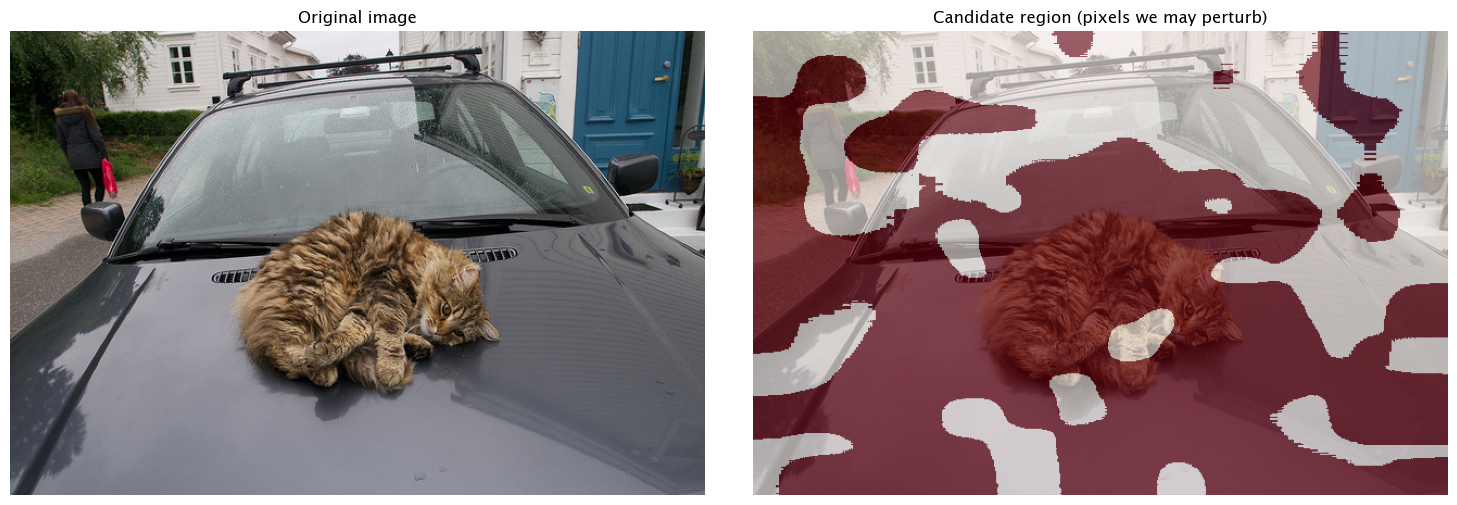

In [98]:
TOPK_PIXELS = 160000

candidate_pixels = get_topk_candidate_pixels(heatmap, k=TOPK_PIXELS)
print("Number of candidate pixels:", len(candidate_pixels))

# optional: visualize
show_candidate_region(base_img, heatmap, candidate_pixels)

In [99]:
blip_base_caption = blip_generate_caption(base_img, deterministic=True)
print("BLIP base caption:", blip_base_caption)

# tokenisieren
caption_ids = blip_processor.tokenizer(
    blip_base_caption,
    return_tensors="pt",
).input_ids.to(device)

base_loss = blip_caption_loss(base_img, caption_ids)
print("BLIP base-caption loss:", base_loss)

BLIP base caption: a cat sleeping on the hood of a car
BLIP base-caption loss: 0.6009263396263123


In [100]:
import numpy as np

base_array = image_to_array(base_img)
num_pixels = len(candidate_pixels)
dim = 3 * num_pixels

EPS_BOUND = 45  # Attack-Stärke (kann später reduziert werden)
ALPHA = 10.0       # Bonus, wenn Caption sich ändert


def clamp_delta(delta, dim, bound):
    if delta.shape[0] != dim:
        if delta.shape[0] > dim:
            delta = delta[:dim]
        else:
            delta = np.pad(delta, (0, dim - delta.shape[0]))
    return np.clip(delta, -bound, +bound)


@torch.no_grad()
def fitness_fn(delta_vec):
    delta = clamp_delta(delta_vec, dim, EPS_BOUND)
    adv_img = apply_perturbation(base_array, delta, candidate_pixels)

    # loss der BLIP-Base-Caption
    loss = blip_caption_loss(adv_img, caption_ids)

    # deterministische BLIP Caption
    adv_cap = blip_generate_caption(adv_img, deterministic=True)
    changed = 0.0 if adv_cap.strip() == blip_base_caption.strip() else 1.0

    return float(loss + ALPHA * changed)

In [101]:
def differential_evolution_blip(
    fitness_fn,
    dim,
    pop_size=100,
    generations=2,
    F=0.8,
    CR=0.9,
    eps=60.0,
):

    rng = np.random.default_rng(42)

    pop = rng.uniform(-eps, +eps, size=(pop_size, dim))
    fitness = np.array([fitness_fn(ind) for ind in pop])

    best_idx = np.argmax(fitness)
    best = pop[best_idx].copy()
    best_fit = fitness[best_idx]

    print(f"Initial best fitness: {best_fit:.4f}")

    for g in range(generations):
        for i in range(pop_size):
            idxs = np.delete(np.arange(pop_size), i)
            r1, r2, r3 = rng.choice(idxs, size=3, replace=False)
            x1, x2, x3 = pop[r1], pop[r2], pop[r3]

            mutant = x1 + F * (x2 - x3)

            cross = rng.random(dim) < CR
            if not np.any(cross):
                cross[rng.integers(dim)] = True

            trial = np.where(cross, mutant, pop[i])
            trial = np.clip(trial, -eps, eps)

            f_trial = fitness_fn(trial)

            if f_trial > fitness[i]:
                pop[i] = trial
                fitness[i] = f_trial

                if f_trial > best_fit:
                    best_fit = f_trial
                    best = trial.copy()

        print(f"Generation {g+1}/{generations}, best fitness = {best_fit:.4f}")

    return best, best_fit


best_delta, best_fitness = differential_evolution_blip(
    fitness_fn,
    dim=dim,
    pop_size=60,
    generations=2,
    eps=EPS_BOUND,
)

print("Best fitness found:", best_fitness)


Initial best fitness: 10.6999
Generation 1/2, best fitness = 10.7468
Generation 2/2, best fitness = 10.7954
Best fitness found: 10.795448362827301


In [102]:
best_delta = clamp_delta(best_delta, dim, EPS_BOUND)
adv_img = apply_perturbation(base_array, best_delta, candidate_pixels)

adv_caption_det = blip_generate_caption(adv_img, deterministic=True)
adv_caption_samp = blip_generate_caption(adv_img, deterministic=False)

print("\n=== BLIP Results ===")
print("Original caption:", blip_base_caption)
print("Adv caption (det):", adv_caption_det)
print("Adv caption (sample):", adv_caption_samp)


=== BLIP Results ===
Original caption: a cat sleeping on the hood of a car
Adv caption (det): a cat is sitting on the hood of a car
Adv caption (sample): two dog paws on a car


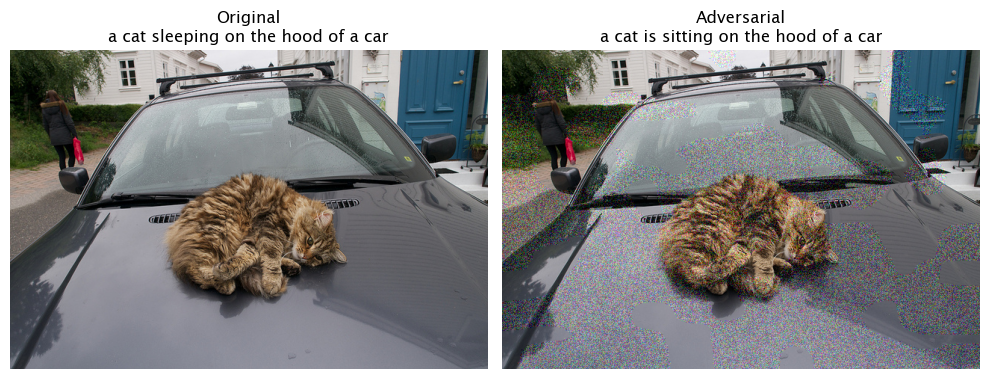

In [103]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(base_img)
plt.title("Original\n" + blip_base_caption)
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(adv_img)
plt.title("Adversarial\n" + adv_caption_det)
plt.axis("off")

plt.tight_layout()
plt.show()

Using device: mps
Base caption: a baseball player pitching a ball on a field 
Initial fitness: 0.0
Generation 1: best fitness=0.7005
Generation 2: best fitness=0.7005
Generation 3: best fitness=0.7005
Generation 4: best fitness=0.7005
Generation 5: best fitness=0.7005
Adversarial caption: a baseball player is about to throw a ball 
Final BLEU drop fitness: 0.7004927194705562


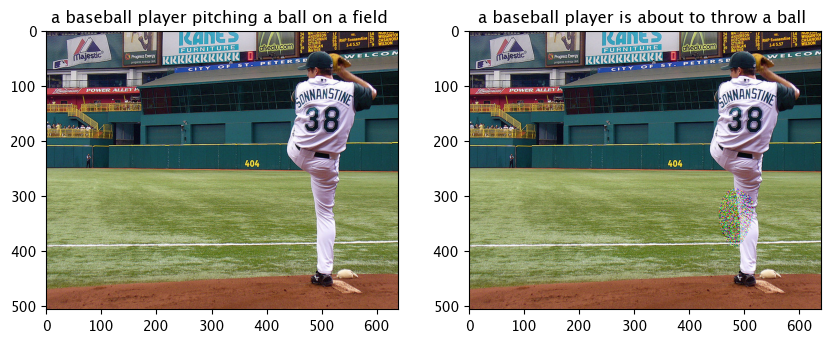

In [149]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from PIL import Image


# GPU setup
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

# =============================================================
# 1) Load ViT-GPT2 Image Captioning Model (CORRECT)
# =============================================================

model_name = "nlpconnect/vit-gpt2-image-captioning"

model = VisionEncoderDecoderModel.from_pretrained(
    model_name,
    attn_implementation="eager").to(device)

feature_extractor = ViTImageProcessor.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

model.eval()


# =============================================================
# 2) Caption Generation (DETERMINISTIC — IMPORTANT!)
# =============================================================

@torch.no_grad()
def generate_caption(img, max_length=20):
    pixel_values = feature_extractor(images=img, return_tensors="pt").pixel_values.to(device)
    out_ids = model.generate(
        pixel_values=pixel_values,
        max_length=max_length,
        num_beams=1,
        do_sample=False,
    )
    return tokenizer.decode(out_ids[0], skip_special_tokens=True)


# =============================================================
# 3) Generate Caption + CROSS-ATTENTION MAPS
# =============================================================

@torch.no_grad()
def generate_caption_and_attention(img, max_length=20):
    """
    Returns:
      - caption (string)
      - cross_attentions (list of layers)
      - encoder_hidden_states
    """
    pixel_values = feature_extractor(images=img, return_tensors="pt").pixel_values.to(device)

    # Encoder pass
    encoder_outputs = model.encoder(pixel_values=pixel_values)
    encoder_hidden_states = encoder_outputs.last_hidden_state  # [1, 197, H]

    # Generate caption
    gen_ids = model.generate(
        pixel_values,
        max_length=max_length,
        num_beams=1,
        do_sample=False,
    )
    caption = tokenizer.decode(gen_ids[0], skip_special_tokens=True)

    # Decoder pass with attention output
    decoder_outputs = model.decoder(
        input_ids=gen_ids,
        encoder_hidden_states=encoder_hidden_states,
        output_attentions=True,
        return_dict=True,
        use_cache=False,
    )

    return caption, decoder_outputs.cross_attentions, encoder_hidden_states


# =============================================================
# 4) Aggregate Cross-Attention → Heatmap
# =============================================================

def aggregate_cross_attention(cross_attentions, img_size, patch_size=14):
    """
    Aggregates cross-attention across:
      - decoder layers
      - heads
      - target positions (caption tokens)
    Then upsamples to image size.
    """
    # Take last decoder layer (paper standard)
    last_layer = cross_attentions[-1]              # [1, heads, tgt_len, src_len]
    last_layer = last_layer.squeeze(0)             # [heads, tgt_len, src_len]

    avg_heads = last_layer.mean(dim=0)             # [tgt_len, src_len]
    avg_tokens = avg_heads.mean(dim=0)             # [src_len]

    # Remove CLS token
    patch_attn = avg_tokens[1:]                    # length = 196 (=14x14)

    # Reshape to patch grid
    attn_map = patch_attn.reshape(patch_size, patch_size).cpu().numpy()

    # Normalize
    attn_map -= attn_map.min()
    attn_map /= (attn_map.max() + 1e-8)

    # Upsample to (W,H)
    W, H = img_size
    heatmap = Image.fromarray((attn_map * 255).astype(np.uint8))
    heatmap = heatmap.resize((W, H), resample=Image.BICUBIC)

    return np.array(heatmap) / 255.0

def debug_generation(delta, g):
    adv_img = apply_perturbation(base_array, delta, candidate_pixels)
    adv_caption = generate_caption(adv_img)
    bleu = weighted_bleu(base_caption, adv_caption)
    print(f"[GEN {g}] adv_caption = '{adv_caption}' | BLEU={bleu:.4f}")



# =============================================================
# 5) Select TOP-K candidate pixels (AICAttack style)
# =============================================================

def get_topk_candidate_pixels(attention_map, k=6000):
    flat = attention_map.flatten()
    idxs = np.argsort(flat)[-k:]    # top-k most attended pixels
    H, W = attention_map.shape
    coords = [(i // W, i % W) for i in idxs]
    return coords



# =============================================================
# 6) Apply perturbation to selected pixels
# =============================================================

def apply_perturbation(base_array, delta_vec, candidate_pixels):
    """
    base_array: uint8 RGB image as numpy array (H,W,3)
    delta_vec: length 3*K
    """
    adv = base_array.astype(np.float32).copy()

    for i, (y, x) in enumerate(candidate_pixels):
        dr = delta_vec[3 * i + 0]
        dg = delta_vec[3 * i + 1]
        db = delta_vec[3 * i + 2]

        adv[y, x, 0] += dr
        adv[y, x, 1] += dg
        adv[y, x, 2] += db

    return np.clip(adv, 0, 255).astype(np.uint8)



# =============================================================
# 7) TRUE AICAttack Fitness = Weighted BLEU Drop
# =============================================================

smooth_fn = SmoothingFunction().method1

def weighted_bleu(ref, hyp):
    ref_list = [ref.split()]
    hyp_list = hyp.split()

    b1 = sentence_bleu(ref_list, hyp_list, weights=(1,0,0,0), smoothing_function=smooth_fn)
    b2 = sentence_bleu(ref_list, hyp_list, weights=(0.5,0.5,0,0), smoothing_function=smooth_fn)
    b3 = sentence_bleu(ref_list, hyp_list, weights=(1/3,1/3,1/3,0), smoothing_function=smooth_fn)
    b4 = sentence_bleu(ref_list, hyp_list, weights=(0.25,0.25,0.25,0.25), smoothing_function=smooth_fn)

    return 0.1*b1 + 0.2*b2 + 0.3*b3 + 0.4*b4

def fitness_bleu(delta_vec):
    delta = np.clip(delta_vec, -EPS_BOUND, EPS_BOUND)
    adv_img = apply_perturbation(base_array, delta, candidate_pixels)

    adv_caption = generate_caption(adv_img)
    bleu = weighted_bleu(base_caption, adv_caption)

    return 1.0 - bleu        # maximize BLEU drop
    


# =============================================================
# 8) Differential Evolution (DE/rand/1/bin)
# =============================================================

def differential_evolution(
    fitness_fn,
    dim,
    pop_size=40,
    generations=5,
    F=0.8,
    CR=0.9,
    eps=30.0,
    seed=42,
):
    rng = np.random.default_rng(seed)

    pop = rng.uniform(-eps, eps, (pop_size, dim))
    fitness = np.array([fitness_fn(ind) for ind in pop])

    best_idx = np.argmax(fitness)
    best = pop[best_idx].copy()
    best_fit = fitness[best_idx]

    print("Initial fitness:", best_fit)

    for g in range(generations):
        for i in range(pop_size):
            r1, r2, r3 = rng.choice(pop_size, 3, replace=False)
            x1, x2, x3 = pop[r1], pop[r2], pop[r3]

            mutant = x1 + F*(x2 - x3)
            mutant = np.clip(mutant, -eps, eps)

            cross = rng.random(dim) < CR
            if not np.any(cross):
                cross[rng.integers(0, dim)] = True

            trial = np.where(cross, mutant, pop[i])
            f_trial = fitness_fn(trial)

            if f_trial > fitness[i]:
                pop[i] = trial
                fitness[i] = f_trial
                if f_trial > best_fit:
                    best_fit = f_trial
                    best = trial.copy()

        print(f"Generation {g+1}: best fitness={best_fit:.4f}")

    return best, best_fit



# =============================================================
# 9) RUN FULL ATTACK
# =============================================================

ATTACK_IDX = idx
base_img, gt_caps = get_image(ATTACK_IDX)

base_caption, cross_attn, enc_states = generate_caption_and_attention(base_img)
print("Base caption:", base_caption)

# Build heatmap and candidate region
heatmap = aggregate_cross_attention(cross_attn, base_img.size)
candidate_pixels = get_topk_candidate_pixels(heatmap, k=5000)

base_array = image_to_array(base_img)
dim = 3 * len(candidate_pixels)
EPS_BOUND = 150

best_delta, best_fit = differential_evolution(
    fitness_fn=fitness_bleu,
    dim=dim,
    pop_size=50,
    generations=5,
    F=0.8,
    CR=0.9,
    eps=EPS_BOUND,
)

adv_img = apply_perturbation(base_array, best_delta, candidate_pixels)
adv_caption = generate_caption(adv_img)

print("Adversarial caption:", adv_caption)
print("Final BLEU drop fitness:", best_fit)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(base_img)
plt.title(base_caption)

plt.subplot(1,2,2)
plt.imshow(adv_img)
plt.title(adv_caption)

plt.show()

In [ ]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# 1) Hilfsfunktion: deterministische Caption (nutzt dein bestehendes Modell)
@torch.no_grad()
def generate_caption(img, max_length=20):
    pixel_values = feature_extractor(images=img, return_tensors="pt").pixel_values.to(device)
    out_ids = model.generate(
        pixel_values=pixel_values,
        max_length=max_length,
        num_beams=1,
        do_sample=False,
    )
    return tokenizer.decode(out_ids[0], skip_special_tokens=True)


# 2) Gradientenbasierte Attacke (PGD artig) auf pixel_values
def gradient_attack_on_image(
    img_pil,
    steps=40,
    step_size=0.02,
    eps=0.2,
    max_length=20
):
    """
    img_pil: PIL.Image
    steps: Anzahl der Iterationen
    step_size: Schrittweite pro Iteration in pixel_values Raum
    eps: maximale L Inf Norm im pixel_values Raum
    """
    model.train()  # für Gradienten, aber ohne Dropout relevant
    model.zero_grad()

    # Ausgangs caption als Target Text
    with torch.no_grad():
        base_caption = generate_caption(img_pil, max_length=max_length)
    print("Base caption:", base_caption)

    # Token ids für Base Caption
    base_ids = tokenizer(
        base_caption,
        return_tensors="pt",
        add_special_tokens=True,
    ).input_ids.to(device)

    # Bild in pixel_values (normalisiert) mit Gradienten
    encoded = feature_extractor(images=img_pil, return_tensors="pt")
    pixel_values = encoded.pixel_values.to(device)
    pixel_values.requires_grad_(True)

    # eps Ball um Original
    orig_pixel_values = pixel_values.detach().clone()

    # Mean und Std für Denormalisierung
    mean = torch.tensor(feature_extractor.image_mean).view(1, 3, 1, 1).to(device)
    std = torch.tensor(feature_extractor.image_std).view(1, 3, 1, 1).to(device)

    for t in range(steps):
        model.zero_grad()

        outputs = model(pixel_values=pixel_values, labels=base_ids)
        loss = outputs.loss  # Cross Entropy für Base Caption

        # Wir wollen Loss MAXIMIEREN (schlechtere Wahrscheinlichkeit für Base Caption)
        (-loss).backward()

        with torch.no_grad():
            # Schritt in Richtung Gradienten
            grad_sign = pixel_values.grad.sign()
            pixel_values = pixel_values + step_size * grad_sign

            # Auf eps Ball um das Original projizieren
            diff = torch.clamp(pixel_values - orig_pixel_values, -eps, eps)
            pixel_values = torch.clamp(orig_pixel_values + diff, -1.0, 1.0)

        pixel_values.requires_grad_(True)

        if (t + 1) % 10 == 0 or t == 0:
            print(f"Step {t+1}/{steps}, loss={loss.item():.4f}")

    # Am Ende: adversariales Bild zurück in Pixelraum holen
    with torch.no_grad():
        img_denorm = pixel_values * std + mean      # zurück in [0,1]
        img_denorm = img_denorm.clamp(0, 1)
        adv_np = img_denorm.squeeze(0).permute(1, 2, 0).cpu().numpy()
        adv_uint8 = (adv_np * 255).astype(np.uint8)
        adv_img = Image.fromarray(adv_uint8)

        adv_caption = generate_caption(adv_img, max_length=max_length)

    model.eval()

    return base_caption, adv_img, adv_caption


# 3) Beispiel für ein Bild aus deinem Datensatz

ATTACK_IDX = idx  # oder feste Zahl
base_img, gt_caps = get_image(ATTACK_IDX)

base_caption, adv_img, adv_caption = gradient_attack_on_image(
    base_img,
    steps=40,
    step_size=0.02,
    eps=0.2,
    max_length=20,
)

print("\nBase caption:       ", base_caption)
print("Adversarial caption:", adv_caption)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(base_img)
plt.title(base_caption)
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(adv_img)
plt.title(adv_caption)
plt.axis("off")
plt.tight_layout()
plt.show()
